# Diamonds

### Импорт библиотек

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor, Pool

import optuna

import kaggle
api = kaggle.KaggleApi()
api.authenticate()

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3824396%2Ff6235a3402992f0fc94af9e0ca3465c2%2Finbox_3824396_4554b5824665256889dafdd5c4c59890_Bbf0GWk.jpg?generation=1588773703548655&amp;alt=media" alt="diamond2">

### Загрузим данные

In [78]:
data = pd.read_csv('data/diamonds_train.csv')
data

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997
...,...,...,...,...,...,...,...,...,...,...,...
40340,40340,1.55,Premium,H,VS2,61.3,61.0,7.46,7.39,4.55,11708
40341,40341,0.36,Ideal,D,SI1,60.6,56.0,4.58,4.63,2.79,619
40342,40342,0.57,Very Good,I,VS2,62.2,55.0,5.33,5.34,3.32,1267
40343,40343,1.01,Very Good,F,IF,59.6,62.0,6.47,6.56,3.88,9965


In [79]:
data.isna().sum().sum(), data.drop('Unnamed: 0', axis=1).duplicated().sum()

(np.int64(0), np.int64(0))

In [80]:
data.drop('Unnamed: 0', axis=1, inplace=True)

##### Пропусков и дублей нет

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40345 entries, 0 to 40344
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40345 non-null  float64
 1   cut      40345 non-null  object 
 2   color    40345 non-null  object 
 3   clarity  40345 non-null  object 
 4   depth    40345 non-null  float64
 5   table    40345 non-null  float64
 6   x        40345 non-null  float64
 7   y        40345 non-null  float64
 8   z        40345 non-null  float64
 9   price    40345 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [82]:
data.describe()

,carat,depth,table,x,y,z,price
count,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000
mean,0.795652,61.750413,57.460302,5.726106,5.730217,3.535136,3924.089924
std,0.470806,1.424219,2.235333,1.118690,1.148584,0.693662,3982.000515
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,948.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2395.000000
75%,1.040000,62.500000,59.000000,6.540000,6.530000,4.030000,5313.000000
max,4.010000,79.000000,95.000000,10.020000,58.900000,8.060000,18818.000000


### Посмотрим на данные

#### Вещественные признаки

In [83]:
data['log_carat'] = np.log1p(data['carat']) 
data['log_price'] = np.log1p(data['price'])

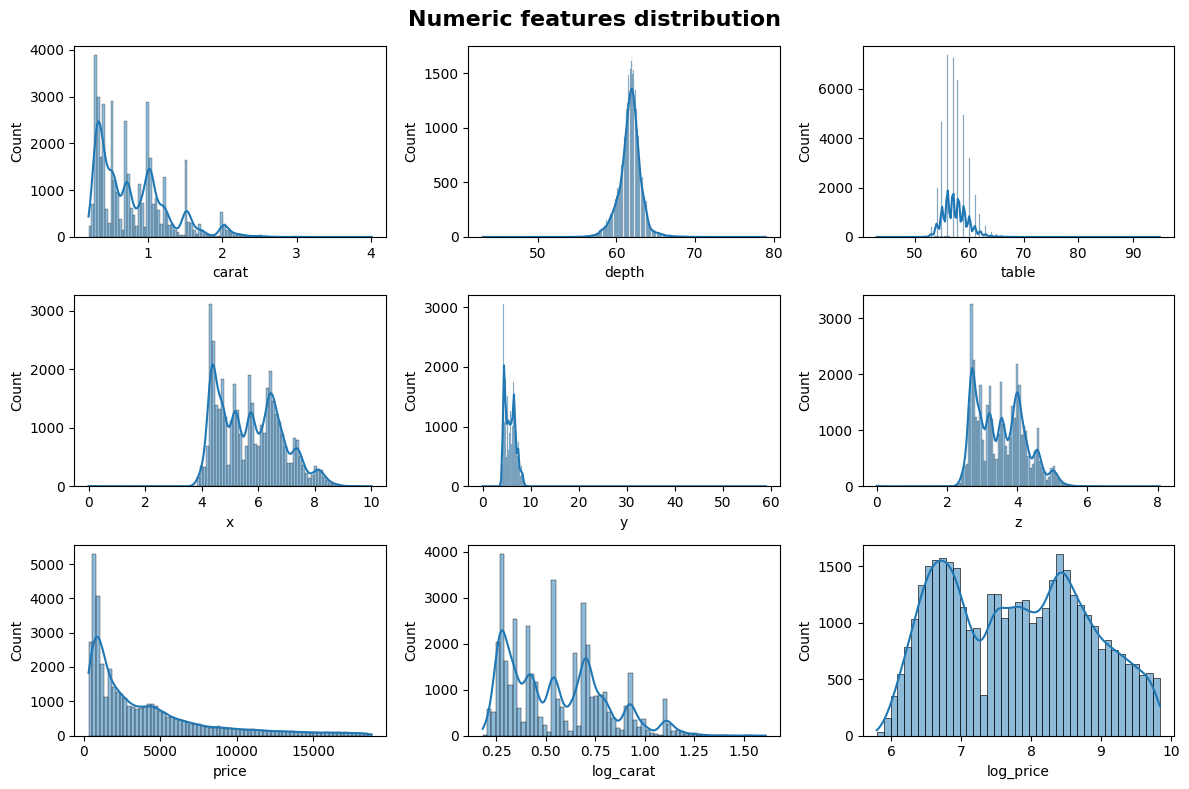

In [84]:
numeric = list(data.select_dtypes(exclude=['object']))
_, axes = plt.subplots(int(np.ceil(len(numeric) / 3)), 3, figsize=(12, 8))
plt.suptitle('Numeric features distribution', fontweight='bold', fontsize=16)
for f, ax in zip(numeric, axes.flatten()):
    sns.histplot(data[f], kde=True, ax=ax)
plt.tight_layout()
plt.show()

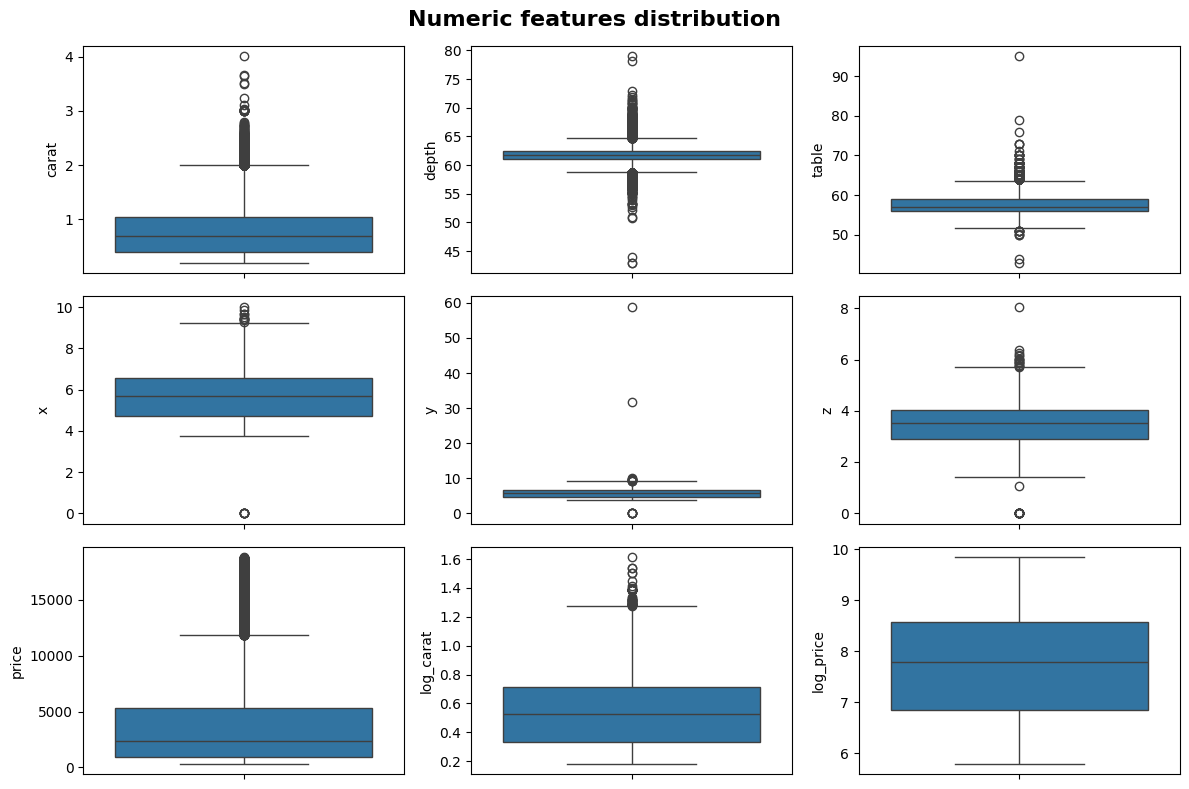

In [85]:
numeric = list(data.select_dtypes(exclude=['object']))
_, axes = plt.subplots(int(np.ceil(len(numeric) / 3)), 3, figsize=(12, 8))
plt.suptitle('Numeric features distribution', fontweight='bold', fontsize=16)
for f, ax in zip(numeric, axes.flatten()):
    sns.boxplot(data[f], ax=ax)
plt.tight_layout()
plt.show()

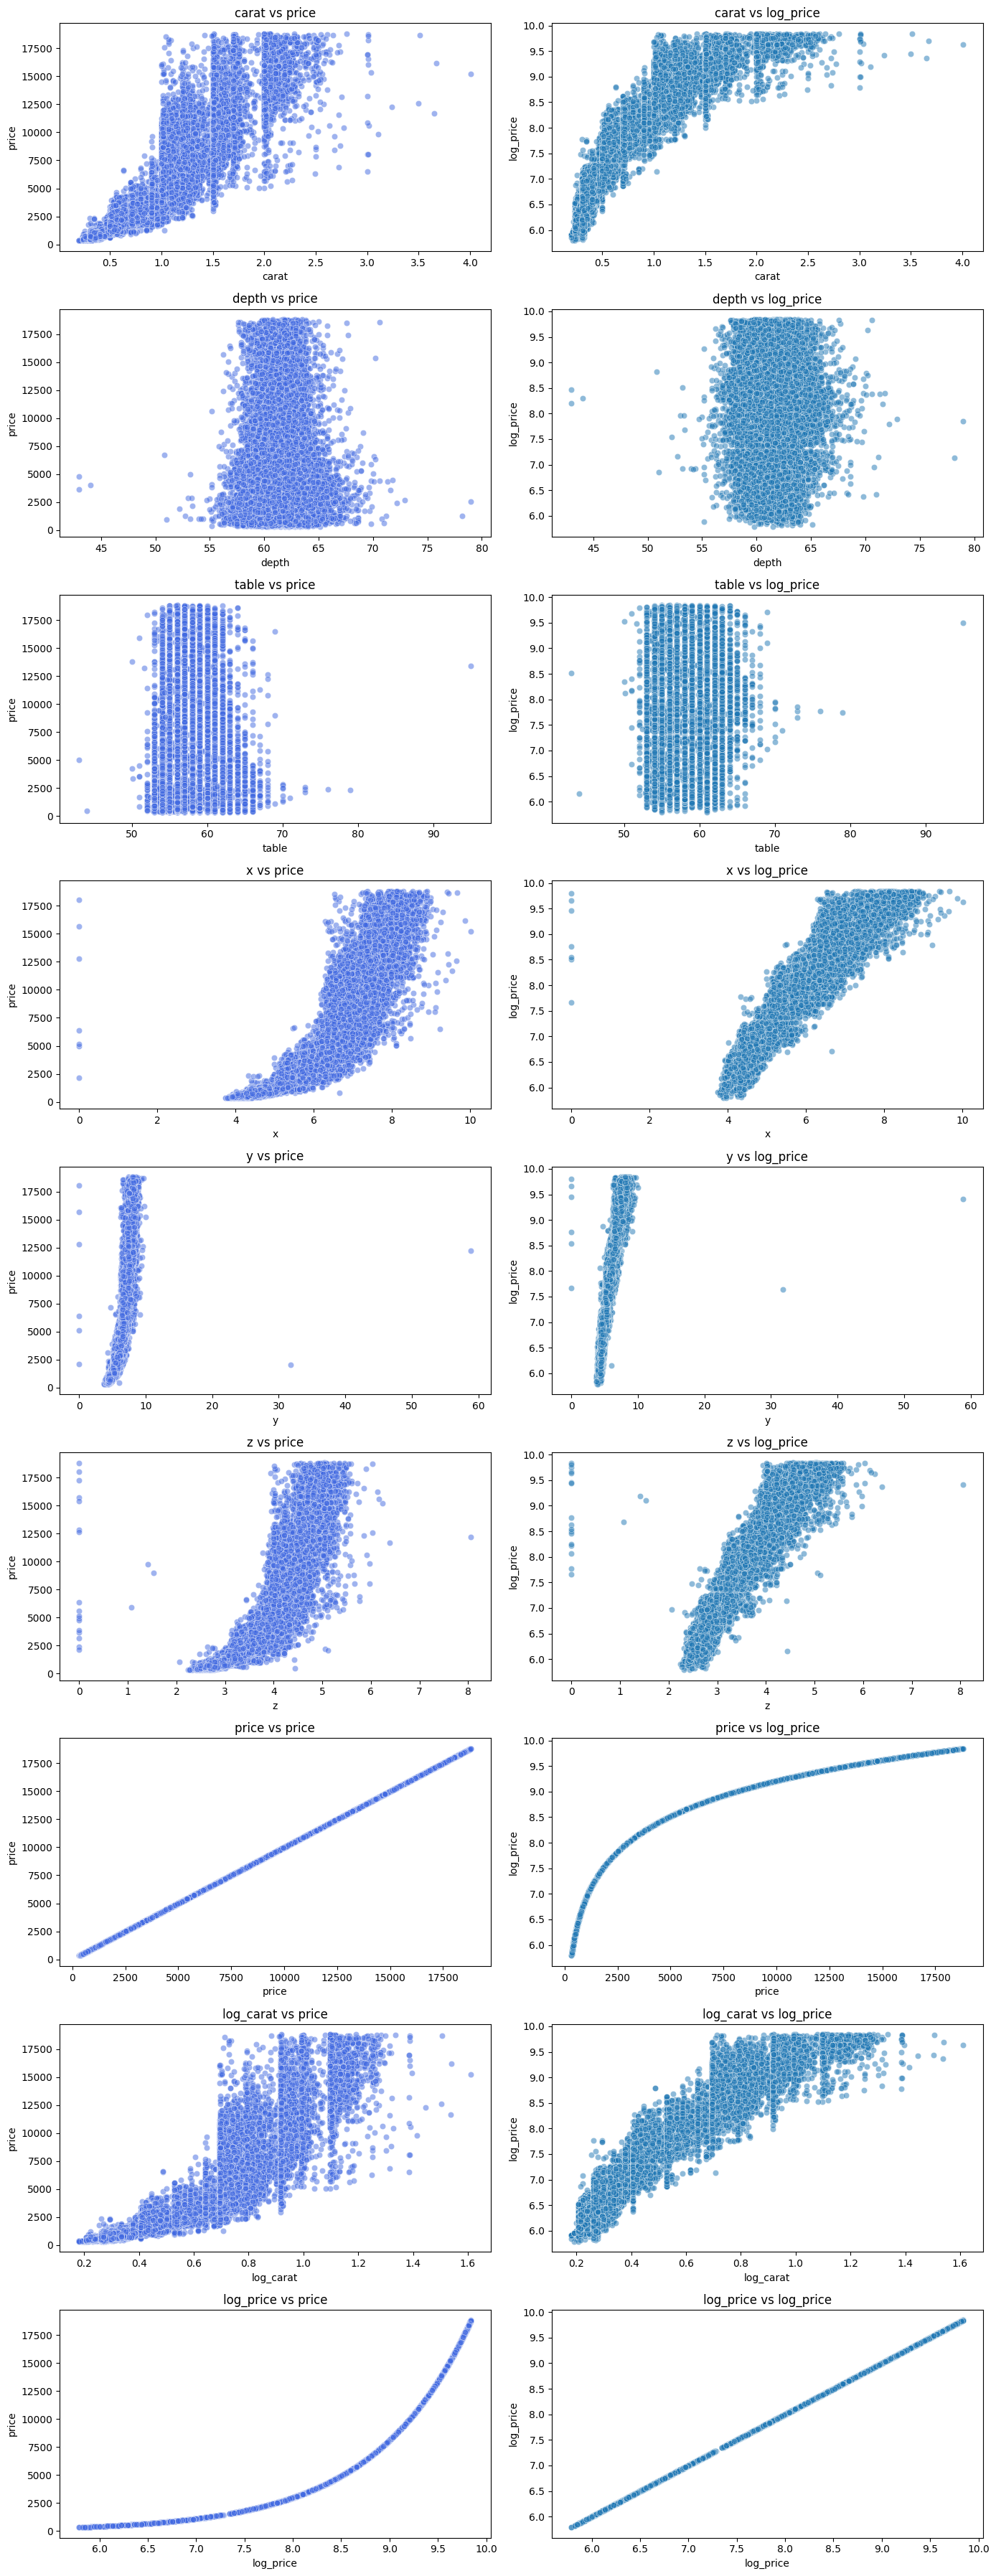

In [86]:
_, axes = plt.subplots(len(numeric), 2, figsize=(14, 4 * len(numeric)))
for i, f in enumerate(numeric):
    sns.scatterplot(x=f, y='price', ax=axes[i, 0], data=data, color='royalblue', alpha=0.5)
    axes[i, 0].set_title(f'{f} vs price')
    sns.scatterplot(x=f, y='log_price', data=data, ax=axes[i, 1], alpha=0.5)
    axes[i, 1].set_title(f'{f} vs log_price')
plt.tight_layout()
plt.show()

#### Категориальные признаки

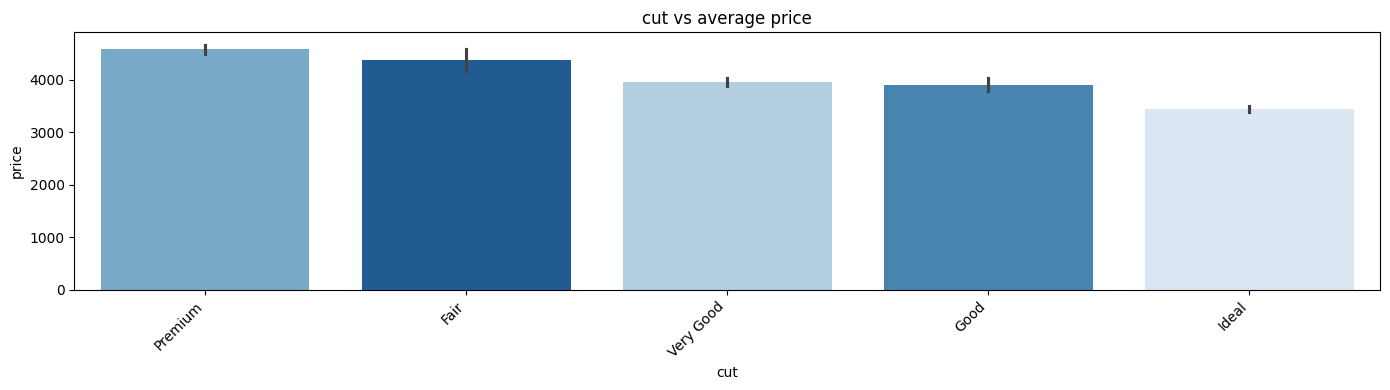

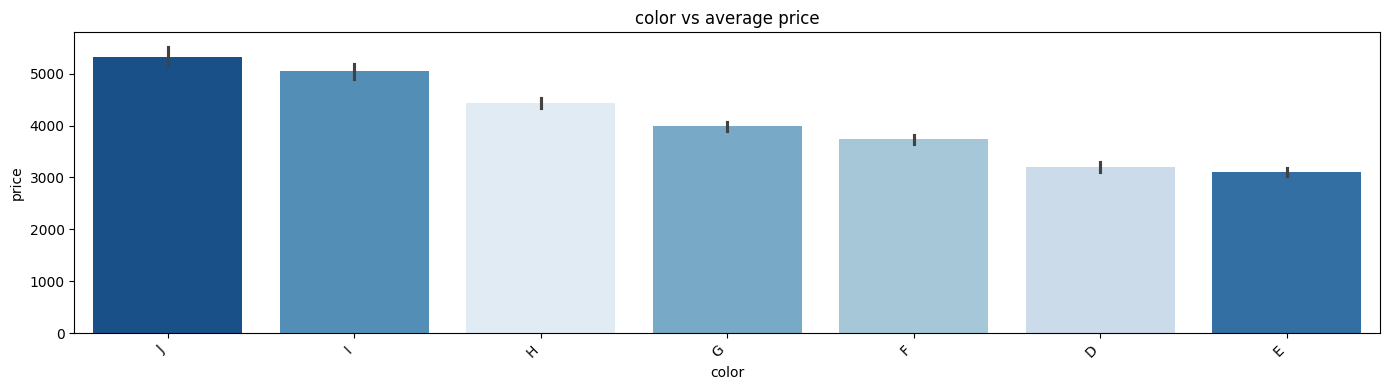

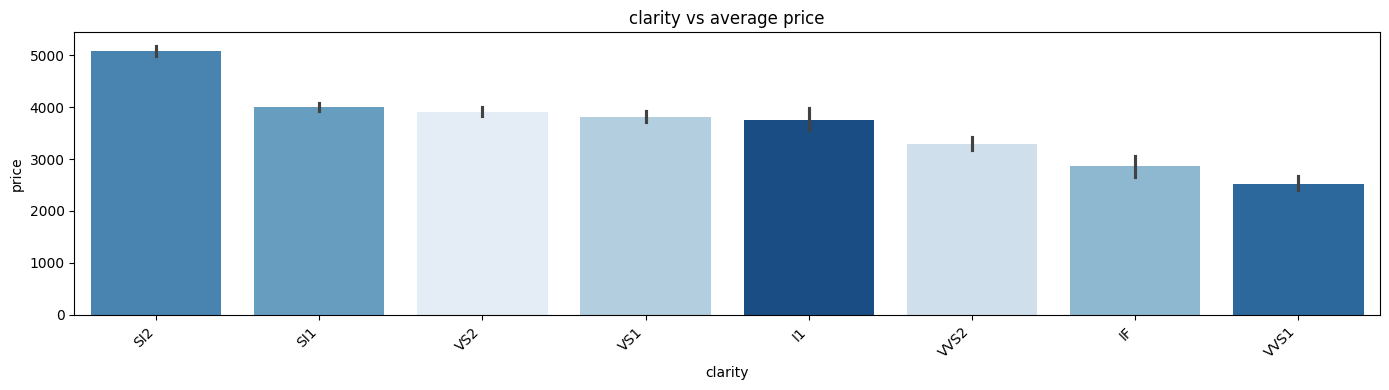

In [87]:
categorical = [f for f in data.columns if f not in numeric]
for f in categorical:
    plt.figure(figsize=(14, 4))
    order = data.groupby(f)['price'].mean().sort_values(ascending=False).index
    sns.barplot(x=f, y='price', data=data, order=order, palette='Blues', hue=f, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{f} vs average price')
    plt.tight_layout()
    plt.show()

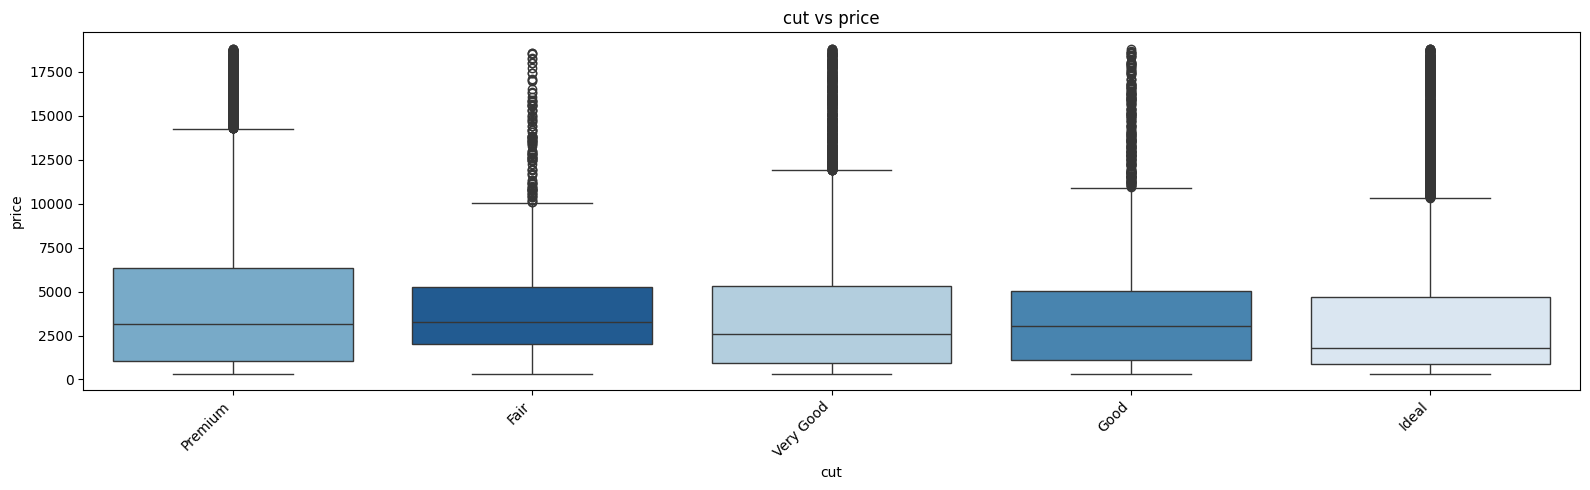

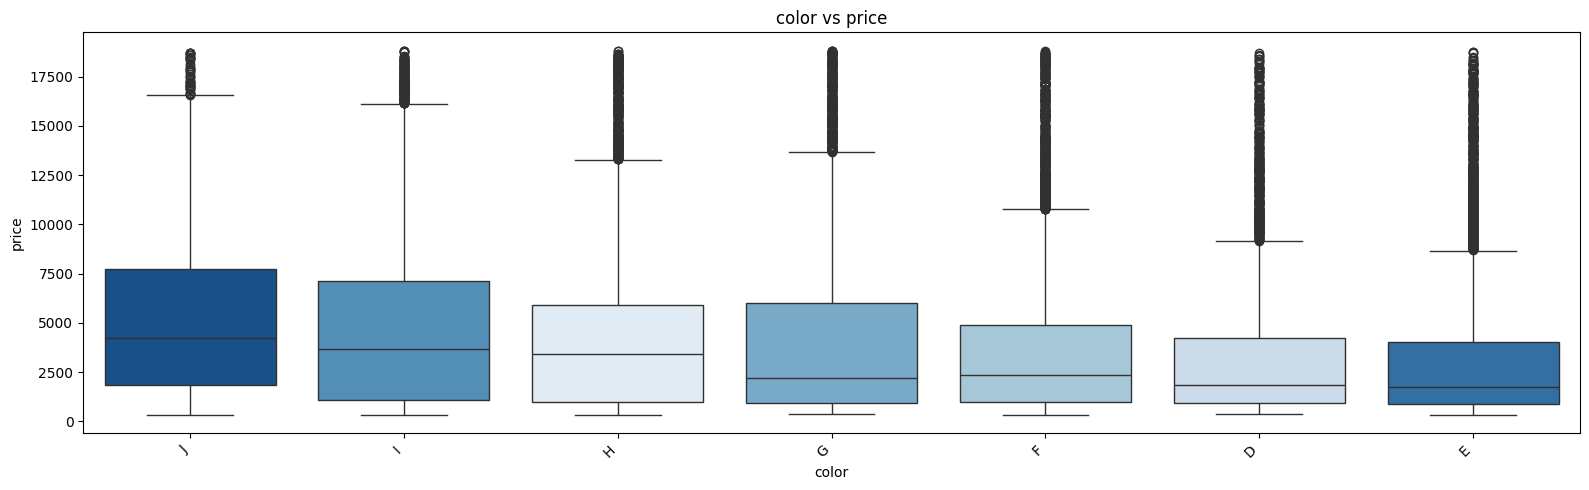

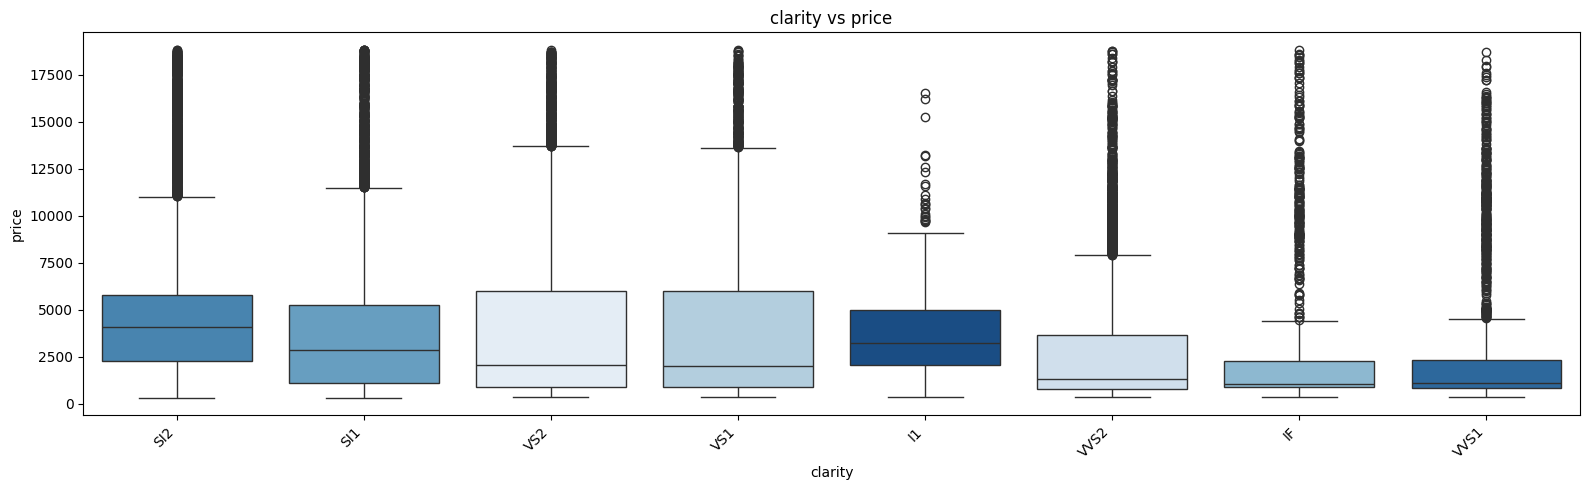

In [88]:
for f in categorical:
    plt.figure(figsize=(16, 5))
    order = data.groupby(f)['price'].mean().sort_values(ascending=False).index
    sns.boxplot(x=f, y='price', data=data, order=order, palette='Blues', hue=f, legend=False)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{f} vs price')
    plt.tight_layout()
    plt.show()

In [89]:
cut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
clarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}

In [90]:
data['num_cut'] = data['cut'].apply(lambda x: cut[x])
data['num_color'] = data['color'].apply(lambda x: color[x])
data['num_clarity'] = data['clarity'].apply(lambda x: clarity[x])

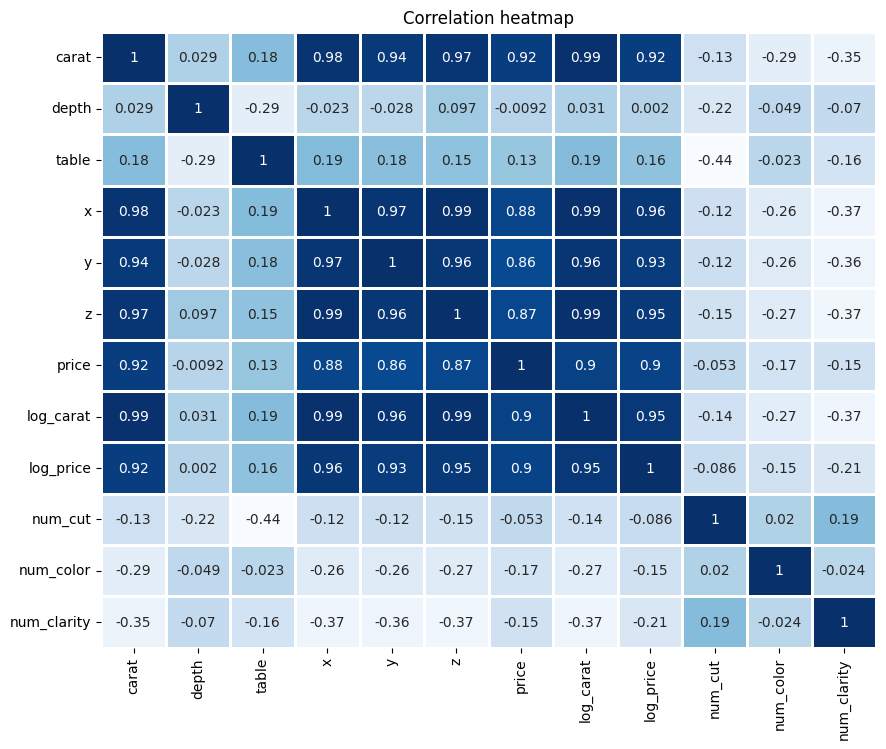

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2, cbar=False)
plt.title('Correlation heatmap')
plt.show()

### Baseline
Построим baseline и вернемся к признакам

In [138]:
data2 = data.copy()
data2 = data2[['carat', 'depth', 'table', 'x', 'y', 'z', 'num_cut', 'num_color', 'num_clarity', 'price']]
train, test = train_test_split(data2, test_size=0.25, random_state=33)
X_train, y_train = train.drop('price', axis=1), train['price']
X_test, y_test = test.drop('price', axis=1), test['price']

In [139]:
scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)

print(f'MSE train set {mean_squared_error(y_train, lasso.predict(X_train).clip(min=0)):.2f}')
print(f'MSE test set {mean_squared_error(y_test, lasso.predict(X_test).clip(min=0)):.2f}')

MSE train set 1352453.84
MSE test set 1320981.53


#### Соберем посылку

In [121]:
test_data = pd.read_csv('data/diamonds_test.csv')
test_data.rename(columns={'Unnamed: 0' : 'id'}, inplace=True)

test_data['num_cut'] = test_data['cut'].apply(lambda x: cut[x])
test_data['num_color'] = test_data['color'].apply(lambda x: color[x])
test_data['num_clarity'] = test_data['clarity'].apply(lambda x: clarity[x])

X_for_sub = test_data[['carat', 'depth', 'table', 'x', 'y', 'z', 'num_cut', 'num_color', 'num_clarity']]
X_for_sub = scaler.transform(X_for_sub)

test_data['price'] = lasso.predict(X_for_sub).clip(min=0)
test_data[['id', 'price']].to_csv('submissons/baseline.csv', index=False)

In [132]:
submissions = api.competition_submissions('diamonds-ds-ft-2109')
print(f'Kaggle score: {submissions[0].to_dict()['publicScore']}')

Kaggle score: 1208.80042


### Вернемся к данным

In [141]:
data = data[(data['x'] > 0) & (data['y'] > 0) & (data['z'] > 0)] # такого не бывает

In [142]:
data['volume'] = data['x'] * data['y'] * data['z'] # примерный объем

data['ratio_xy'] = data['x'] / data['y'] # отношение сорон
data['ratio_xz'] = data['x'] / data['z']
data['ratio_yz'] = data['y'] / data['z']

data['surface'] = 2 * (data['x'] * data['y'] + data['y'] * data['z'] + data['x'] * data['z']) # поверхность

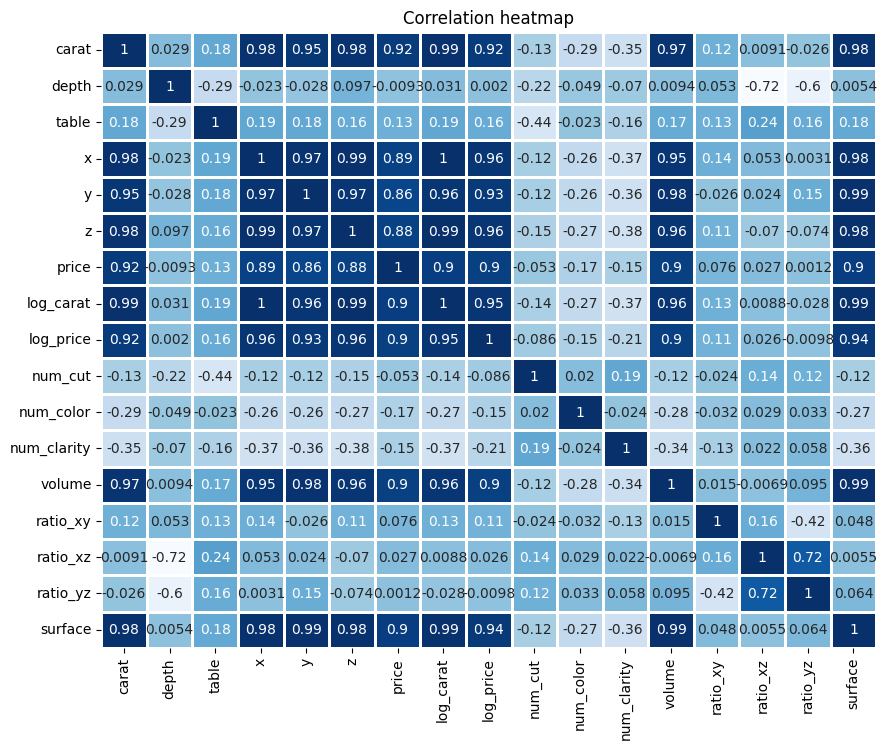

In [146]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues', linewidths=2, cbar=False)
plt.title('Correlation heatmap')
plt.show()

### Попробуем CatBoost

In [167]:
class AddNewFeatures(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self
    def transform(self, X, y=None):
        X = X.copy()
        X['volume'] = X['x'] * X['y'] * X['z']
        X['ratio_xy'] = X['x'] / X['y']
        X['ratio_xz'] = X['x'] / X['z']
        X['ratio_yz'] = X['y'] / X['z']
        X['surface'] = 2 * (X['x'] * X['y'] + X['y'] * X['z'] + X['x'] * X['z'])
        return X
    
class DiamondsEncoder(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self
    def transform(self, X, y=None):
        X = X.copy()
        cut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
        color = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
        clarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
        X['num_cut'] = X['cut'].apply(lambda x: cut[x])
        X['num_color'] = X['color'].apply(lambda x: color[x])
        X['num_clarity'] = X['clarity'].apply(lambda x: clarity[x])
        return X.drop(['cut', 'color', 'clarity'], axis=1)

In [168]:
data = pd.read_csv('data/diamonds_train.csv')
X, y = data.drop(['Unnamed: 0', 'price'], axis=1), data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)

In [169]:
pipeline = Pipeline([
    ('features', AddNewFeatures()),
    ('encoder', DiamondsEncoder())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [173]:
def objective(trial : optuna.Trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1500),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.5, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'verbose': 0,
        'random_seed': 33,
        'loss_function': 'RMSE',
        'early_stopping_rounds': 100
    }

    model = CatBoostRegressor(**params)
    train_pool = Pool(X_train, y_train)
    
    model.fit(train_pool, verbose=False)
    
    preds = model.predict(X_test)
    mse = root_mean_squared_error(y_test, preds)
    
    return mse

In [174]:
study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)

[I 2025-10-22 19:22:27,914] A new study created in memory with name: no-name-90ccc77d-b024-4d0c-99c9-a9cb50b42094


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-22 19:22:30,421] Trial 5 finished with value: 532.2770521071159 and parameters: {'iterations': 364, 'depth': 5, 'learning_rate': 0.1792795646766468, 'l2_leaf_reg': 4.61939407079094, 'bagging_temperature': 1.4331792441829723, 'border_count': 55, 'random_strength': 7.21326986350429, 'min_data_in_leaf': 15}. Best is trial 5 with value: 532.2770521071159.
[I 2025-10-22 19:22:31,640] Trial 7 finished with value: 526.2304080377933 and parameters: {'iterations': 1005, 'depth': 4, 'learning_rate': 0.1932382320675772, 'l2_leaf_reg': 2.653648735489655, 'bagging_temperature': 1.62923394314788, 'border_count': 217, 'random_strength': 8.689859014142582, 'min_data_in_leaf': 8}. Best is trial 7 with value: 526.2304080377933.
[I 2025-10-22 19:22:33,684] Trial 8 finished with value: 521.8754626062267 and parameters: {'iterations': 382, 'depth': 6, 'learning_rate': 0.07830899872453394, 'l2_leaf_reg': 0.021339712747815674, 'bagging_temperature': 0.15357947334509658, 'border_count': 105, 'rando

In [175]:
optuna.visualization.plot_optimization_history(study)

In [176]:
optuna.visualization.plot_param_importances(study)

In [ ]:
catboost_with_hp = CatBoostRegressor(**study.best_params)
catboost_with_hp.fit(Pool(X_train, y_train), verbose=100)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 3911.2541366	total: 3.82ms	remaining: 4.55s
100:	learn: 881.1037191	total: 243ms	remaining: 2.63s
200:	learn: 580.1126406	total: 465ms	remaining: 2.29s
300:	learn: 526.7528368	total: 677ms	remaining: 2.01s
400:	learn: 504.2295057	total: 909ms	remaining: 1.79s
500:	learn: 488.6101279	total: 1.12s	remaining: 1.54s
600:	learn: 477.6460127	total: 1.32s	remaining: 1.3s
700:	learn: 467.0474264	total: 1.53s	remaining: 1.07s
800:	learn: 457.7268914	total: 1.73s	remaining: 848ms
900:	learn: 449.1557655	total: 1.98s	remaining: 643ms
1000:	learn: 440.9875828	total: 2.24s	remaining: 431ms
1100:	learn: 433.5216095	total: 2.47s	remaining: 207ms
1192:	learn: 426.3373851	total: 2.7s	remaining: 0us


In [183]:
print(f'MSE train set {mean_squared_error(y_train, catboost_with_hp.predict(X_train).clip(min=0)):.2f}')
print(f'MSE test set {mean_squared_error(y_test, catboost_with_hp.predict(X_test).clip(min=0)):.2f}')

MSE train set 181763.57
MSE test set 264189.82


### Соберем посылку

In [186]:
test_data = pd.read_csv('data/diamonds_test.csv')
test_data.rename(columns={'Unnamed: 0' : 'id'}, inplace=True)

X_for_sub = pipeline.transform(test_data.drop('id', axis=1))

test_data['price'] = catboost_with_hp.predict(X_for_sub).clip(min=0)
test_data[['id', 'price']].to_csv('submissons/catboost.csv', index=False)

In [187]:
submissions = api.competition_submissions('diamonds-ds-ft-2109')
print(f'Kaggle score: {submissions[0].to_dict()['publicScore']}')

Kaggle score: 521.00491


#### Обучим на всем сете

In [188]:
train_data = pd.read_csv('data/diamonds_train.csv')
train_data = train_data[(train_data['x'] > 0) & (train_data['y'] > 0) & (train_data['z'] > 0)]
train_data.drop('Unnamed: 0', axis=1, inplace=True)

X_train, y_train = train_data.drop('price', axis=1), train_data['price']

X_train = pipeline.transform(X_train)

In [190]:
catboost_with_hp.fit(Pool(X_train, y_train), verbose=100)

print(f'MSE train set {mean_squared_error(y_train, catboost_with_hp.predict(X_train).clip(min=0)):.2f}')
test_data['price'] = catboost_with_hp.predict(X_for_sub).clip(min=0)
test_data[['id', 'price']].to_csv('submissons/catboost_all_set.csv', index=False)

0:	learn: 3902.9527040	total: 5.38ms	remaining: 6.41s
100:	learn: 877.5042667	total: 262ms	remaining: 2.84s
200:	learn: 578.5186427	total: 548ms	remaining: 2.7s
300:	learn: 528.3091992	total: 793ms	remaining: 2.35s
400:	learn: 507.0092699	total: 1.09s	remaining: 2.14s
500:	learn: 493.6782716	total: 1.34s	remaining: 1.85s
600:	learn: 482.8060642	total: 1.57s	remaining: 1.55s
700:	learn: 473.2500111	total: 1.82s	remaining: 1.28s
800:	learn: 464.6506601	total: 2.06s	remaining: 1.01s
900:	learn: 456.8192341	total: 2.33s	remaining: 755ms
1000:	learn: 449.3992945	total: 2.62s	remaining: 502ms
1100:	learn: 442.2428853	total: 2.86s	remaining: 239ms
1192:	learn: 436.0921708	total: 3.1s	remaining: 0us
MSE train set 190176.38


In [191]:
submissions = api.competition_submissions('diamonds-ds-ft-2109')
print(f'Kaggle score: {submissions[0].to_dict()['publicScore']}')

Kaggle score: 529.88008
